# 413 Coursework 2

## Research Question: Can you predict an MP's polictal party from their tweets

In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [14]:
working_folder = '/content/gdrive/MyDrive/413/Coursework2/'

In [15]:
import sys
sys.path.append(working_folder)

In [16]:
!pip install ftfy

In [17]:
import nltk
nltk.download('punkt')  # download tokeniser models, will download first time.
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import json
import math
import ftfy
import re
from nltk.corpus import stopwords
from collections import Counter
from os.path import splitext, split
import os
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(0)

Class defining a document, which has been taken an slightly modified from the workshop exercises, we use it to store the tokens for each MP

In [19]:
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter()  # empty counter, ready to be added to with Counter.update.

    def extract_features(self, data, tokeniser, hashtagMention):  # document should be iterable text lines, e.g. read in from file.
        # Defining the set of stop words and punctuation to remove.
        stop_words = set(stopwords.words('english'))
        stop_words.update({',', '.', '"', '!', '&', "'", '?', ':'})
        texts = pre_process_data(data, hashtagMention)
        for text in texts:
            tokens = tokeniser.tokenize(text)
            filtered = [w for w in tokens if not w.lower() in stop_words]
            lower_tokens = [t.lower() for t in filtered]
            self.tokens_fql.update(
                lower_tokens)  # updating Counter counts items in list, adding to existing Counter items.

    def get_ttr(self):  # type token ratio
        length_types = len(self.tokens_fql)
        length_tokens = sum(self.tokens_fql.values())
        return length_types / length_tokens

Defining the base methods which we will need for pre-processing and processing the data

In [40]:
def pre_process_data(data, hashtagMention):
    # Defining the regular expressions to use in pre-processing
    hashtag = re.compile(r'#')
    mention = re.compile(r'@')
    urls = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    newline = re.compile(r'\n')
    text = []
    # Try replacing with space at some point
    for d in data:
        t = ftfy.fix_text(d.get('full_text'))
        if hashtagMention:
            t = hashtag.sub(' ', t)
            t = mention.sub(' ', t)
        t = urls.sub(' ', t)
        t = newline.sub(' ', t)
        text.append(t)
    return text

# Method to load all the tweets from an MP's JSON file
def load_data(path):
    with open(path, encoding='utf-8') as fh:
        data = json.load(fh)
    return data

# Calculate the term frequency of a document, if term is not in doc, return 0
def tf(term, doc):
    if term in doc:
        tfe = doc[term]
    else:
        tfe = 0
    return tfe / sum(doc.values())  # term freq / total terms (relative term freq)


def num_containing(term, corpus):
    return sum(1 for doc in corpus if term in doc)  # counts docs in corpus containing term.


# 1 added to numerator and denominator is for preventing division by zero. Equivalent of an extra document containing
# all terms once.
def idf(term, corpus):
    n_t = num_containing(term, corpus)
    return math.log((len(corpus) + 1) / ((n_t) + 1))

# Calculate term frequency - inverse document frequency
def tfidf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

# Function to create the documents of MPs for both parties, with parameters for the tokeniser and whether hashtag and mention and included
def import_party_folder(party, tokeniser, hashtagMention):
    textfiles = os.listdir(working_folder+'/'+party+'/')
    for tf in textfiles:
        username = splitext(split(tf)[1])[0]  # extract just username from filename.
        print("Processing " + username)
        doc = Document({'username': username, 'party': party})  # include metadata
        tweets = load_data(working_folder+'/'+party+'/'+tf)
        doc.extract_features(tweets, tokeniser, hashtagMention)
        yield doc

# Function to create the current corpus of both paries, with parameters for the tokeniser and whether hashtag and mention and included
def generateCorpus(tokeniser, hashtagMention):
    corpus = []
    corpus.extend(import_party_folder("labour", tokeniser, hashtagMention))
    corpus.extend(import_party_folder("conservatives", tokeniser, hashtagMention))

    return corpus

Method which vectorises the current corpus in to a bag of words model, with TF-IDF

In [41]:
def vectorize(corpus):
    # Finding the total frequency of each token across all documents 
    corpus_fqls = {k: corpus[0].tokens_fql.get(k, 0) + corpus[1].tokens_fql.get(k, 0) for k in set(corpus[0].tokens_fql) | set(corpus[1].tokens_fql)}
    for i in range(1, len(corpus)):
        corpus_fqls = {k: corpus_fqls.get(k, 0) + corpus[i].tokens_fql.get(k, 0) for k in set(corpus_fqls) | set(corpus[i].tokens_fql)}
    # Creating array of token frequencies
    corpus_fqls2 = [doc.tokens_fql for doc in corpus]
    corpus_vectorized = []
    # Creating array containing tf-idf for each term in the corpus for each document
    for doc in corpus:
        corpus_vectorized.append([tfidf(term, doc.tokens_fql, corpus_fqls2) for term in corpus_fqls])
    return corpus_vectorized

Method to take the corpus and classifier, then train and predict

In [42]:
def classification(corpus, clf):
    labels = ['labour'] * 20 + ['conservatives'] * 20
    # Creating train and test split at 80/20
    X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, stratify=labels)

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    return accuracy_score(y_test, predictions)

Defining the classifiers and the loops for each of the 4 classifiers

In [24]:
def createClassifiers(corpus):
    # Method which just runs the experiment of predicting party, 50 times for each classifier
    corpus = vectorize(corpus)
    allAccuracy = []
    print('Random Forest:')
    RFAccuracy = []
    trf = 0
    for i in range(50):
        clf = RandomForestClassifier()
        trf += classification(corpus, clf)
        RFAccuracy.append(trf/(i+1))
    print('Over 50 iterations, Accuracy: '+str(RFAccuracy[-1]))
    allAccuracy.append(RFAccuracy)

    print('K Nearest Neighbour:')
    KNNAccuracy = []
    tknn = 0
    for i in range(50):
        clf = KNeighborsClassifier(n_neighbors=3)
        tknn += classification(corpus, clf)
        KNNAccuracy.append(tknn/(i+1))
    print('Over 50 iterations, Accuracy: '+str(KNNAccuracy[-1]))
    allAccuracy.append(KNNAccuracy)

    print('Naive bayes:')
    NBAccuracy = []
    tnb = 0
    for i in range(50):
        clf = GaussianNB()
        tnb += classification(corpus, clf)
        NBAccuracy.append(tnb/(i+1))
    print('Over 50 iterations, Accuracy: '+str(NBAccuracy[-1]))
    allAccuracy.append(NBAccuracy)

    print('Logistic Regression:')
    LRAccuracy = []
    tmlp = 0
    for i in range(50):
        clf = LogisticRegression(solver='saga')
        tmlp += classification(corpus, clf)
        LRAccuracy.append(tmlp/(i+1))
    print('Over 50 iterations, Accuracy: '+str(LRAccuracy[-1]))
    allAccuracy.append(LRAccuracy)

    return allAccuracy

# Predicting MP's Party

Here for each combination of tokeniser and hashtag and mention included, we create the corpus, run the experiments and then plot the results.

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Twitter Tokeniser:
Random

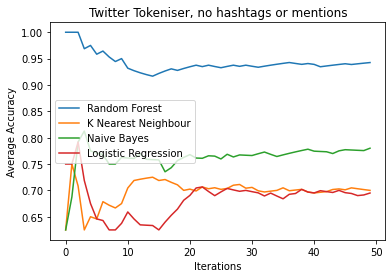

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Tree Bank Word Tokeniser:

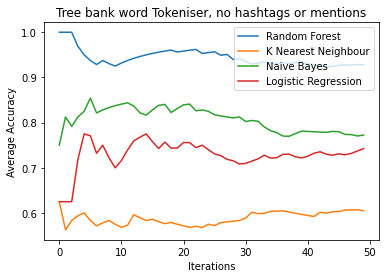

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Whitespace Tokeniser:
Ran

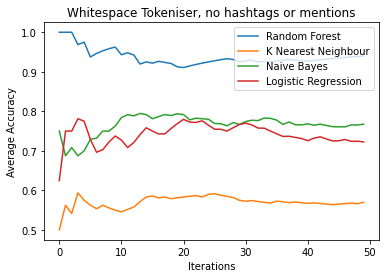

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Twitter Tokeniser:
Random

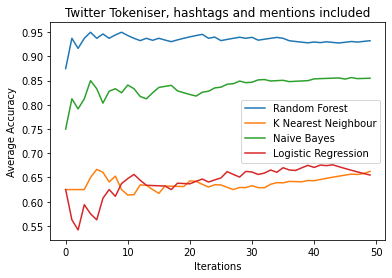

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Tree Bank Word Tokeniser:

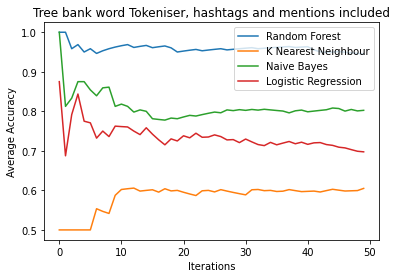

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Created Corpus with Whitespace Tokeniser:
Ran

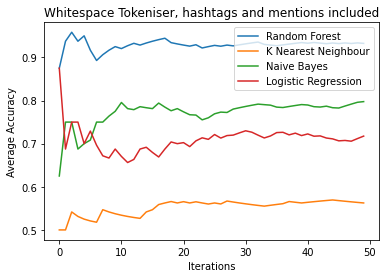

In [25]:
%matplotlib inline

x = list(range(0, 50))

# 0: Twitter Tokeniser, 1: Tree Bank Word Tokeniser, 2: Whitespace Tokeniser
twtok = nltk.tokenize.TweetTokenizer()
corpus = generateCorpus(twtok, hashtagMention=True)
print('Created Corpus with Twitter Tokeniser:')
results1 = createClassifiers(corpus)

plt.plot(x, results1[0], label = "Random Forest")
plt.plot(x, results1[1], label = "K Nearest Neighbour")
plt.plot(x, results1[2], label = "Naive Bayes")
plt.plot(x, results1[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Twitter Tokeniser, no hashtags or mentions")
plt.show()

trbwordtok = nltk.tokenize.TreebankWordTokenizer()
corpus = generateCorpus(trbwordtok, hashtagMention=True)
print('Created Corpus with Tree Bank Word Tokeniser:')
results2 = createClassifiers(corpus)

plt.plot(x, results2[0], label = "Random Forest")
plt.plot(x, results2[1], label = "K Nearest Neighbour")
plt.plot(x, results2[2], label = "Naive Bayes")
plt.plot(x, results2[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Tree bank word Tokeniser, no hashtags or mentions")
plt.show()

whitetok = nltk.tokenize.WhitespaceTokenizer()
corpus = generateCorpus(whitetok, hashtagMention=True)
print('Created Corpus with Whitespace Tokeniser:')
results3 = createClassifiers(corpus)

plt.plot(x, results3[0], label = "Random Forest")
plt.plot(x, results3[1], label = "K Nearest Neighbour")
plt.plot(x, results3[2], label = "Naive Bayes")
plt.plot(x, results3[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Whitespace Tokeniser, no hashtags or mentions")
plt.show()

twtok = nltk.tokenize.TweetTokenizer()
corpus = generateCorpus(twtok, hashtagMention=False)
print('Created Corpus with Twitter Tokeniser:')
results1 = createClassifiers(corpus)

plt.plot(x, results1[0], label = "Random Forest")
plt.plot(x, results1[1], label = "K Nearest Neighbour")
plt.plot(x, results1[2], label = "Naive Bayes")
plt.plot(x, results1[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Twitter Tokeniser, hashtags and mentions included")
plt.show()

trbwordtok = nltk.tokenize.TreebankWordTokenizer()
corpus = generateCorpus(trbwordtok, hashtagMention=False)
print('Created Corpus with Tree Bank Word Tokeniser:')
results2 = createClassifiers(corpus)

plt.plot(x, results2[0], label = "Random Forest")
plt.plot(x, results2[1], label = "K Nearest Neighbour")
plt.plot(x, results2[2], label = "Naive Bayes")
plt.plot(x, results2[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Tree bank word Tokeniser, hashtags and mentions included")
plt.show()

whitetok = nltk.tokenize.WhitespaceTokenizer()
corpus = generateCorpus(whitetok, hashtagMention=False)
print('Created Corpus with Whitespace Tokeniser:')
results3 = createClassifiers(corpus)

plt.plot(x, results3[0], label = "Random Forest")
plt.plot(x, results3[1], label = "K Nearest Neighbour")
plt.plot(x, results3[2], label = "Naive Bayes")
plt.plot(x, results3[3], label = "Logistic Regression")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Accuracy")
plt.title("Whitespace Tokeniser, hashtags and mentions included")
plt.show()


# Looking for Outliers in MP's when predicting the partys of MP's

This method we create and validate each classifier using the leave one out cross validation method

In [43]:
def findingOftenMissclassified(corpus, clf):
    corpus = np.array(corpus)
    finalPredictions = []

    labels = ['labour'] * 20 + ['conservatives'] * 20
    labels = np.array(labels)
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(corpus):
        X_train, X_test = corpus[train_index], corpus[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        clf.fit(X_train, y_train)

        predictions = clf.predict(X_test)
        if y_test[0] == 'labour':
            if predictions[0] == y_test[0]:
                finalPredictions.append(1)
            else:
                finalPredictions.append(-1)
        else:
            if predictions[0] == y_test[0]:
                finalPredictions.append(-1)
            else:
                finalPredictions.append(1)
    return finalPredictions

We run the method 50 times, so we can see how many times each MP was classified as either labour or conservative in 50 attempts

In [44]:
twtok = nltk.tokenize.TweetTokenizer()
corpus = generateCorpus(twtok, hashtagMention=False)
corpusV = vectorize(corpus)
totalPredictions = [0]*40
print('Random Forest:')
for i in range(50):
    clf = RandomForestClassifier()
    predictions = findingOftenMissclassified(corpusV, clf)
    totalPredictions = [a + b for a,b in zip(totalPredictions, predictions)]

Processing Keir_Starmer
Processing Ed_Miliband
Processing DavidLammy
Processing AngelaRayner
Processing HackneyAbbott
Processing YvetteCooperMP
Processing johnmcdonnellMP
Processing lisanandy
Processing EmilyThornberry
Processing zarahsultana
Processing DawnButlerBrent
Processing DrRosena
Processing TulipSiddiq
Processing RLong_Bailey
Processing HarrietHarman
Processing hilarybennmp
Processing RichardBurgon
Processing RhonddaBryant
Processing stellacreasy
Processing jessphillips
Processing BorisJohnson
Processing theresa_may
Processing RishiSunak
Processing Jacob_Rees_Mogg
Processing MattHancock
Processing pritipatel
Processing DominicRaab
Processing sajidjavid
Processing michaelgove
Processing Jeremy_Hunt
Processing trussliz
Processing DavidDavisMP
Processing grantshapps
Processing SteveBakerHW
Processing johnredwood
Processing andrealeadsom
Processing NadineDorries
Processing JohnnyMercerUK
Processing JamesCleverly
Processing TomTugendhat
Random Forest:


Then we create the heatmap of the output

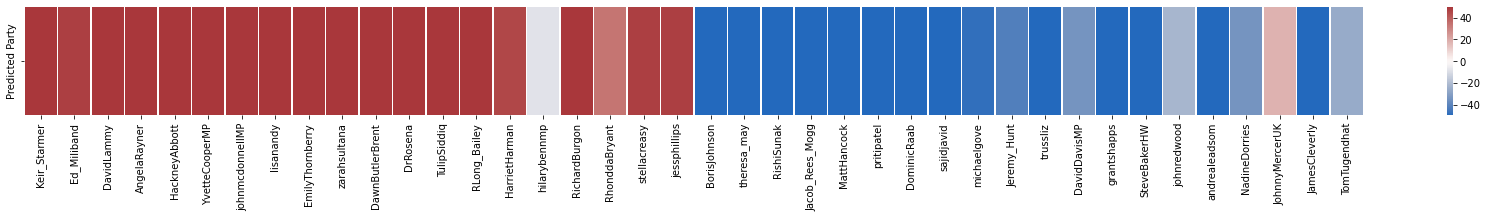

In [45]:
totalPredictions = np.array(totalPredictions)
columns = np.array([str(doc.meta['username']) for doc in corpus])
data = {c:[t] for c, t in zip(columns, totalPredictions)}
df = pd.DataFrame(data, index=['Predicted Party'])

plt.figure(figsize=(30,2))
sns.heatmap(df, cmap='vlag', linewidths=0.5)